In [1]:
from matplotlib import pyplot as plt
from PIL import Image

import torch as pt
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomApply(
        nn.ModuleList([
            transforms.ColorJitter(brightness=0.3),
        ]), p=0.4
    ),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
])

In [3]:
trainset = datasets.ImageFolder("./data/train", transform=transforms_)
testset = datasets.ImageFolder("./data/test", transform=transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
]))

In [4]:
CLASSES = trainset.classes
batch_size = 32
device = "cuda" if pt.cuda.is_available() else "cpu"

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
print (f"Total number of samples found in Train Set are: {len(trainloader.dataset)}")
print (f"Total number of samples found in Test Set are: {len(testloader.dataset)}")

Total number of samples found in Train Set are: 14034
Total number of samples found in Test Set are: 3000


In [7]:
n_samples_per_class = {
    "mountain": 0, "buildings": 0, "glacier": 0,
    "forest": 0, "street": 0, "sea": 0,
}

In [8]:
for _, labels in trainloader:
    for label in labels:
        n_samples_per_class[CLASSES[label.item()]] += 1

<BarContainer object of 6 artists>

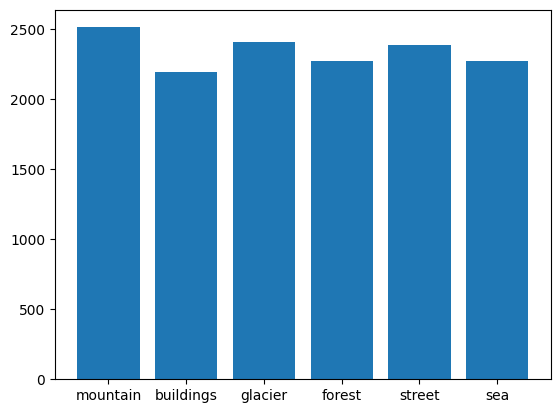

In [9]:
plt.bar(n_samples_per_class.keys(), n_samples_per_class.values())

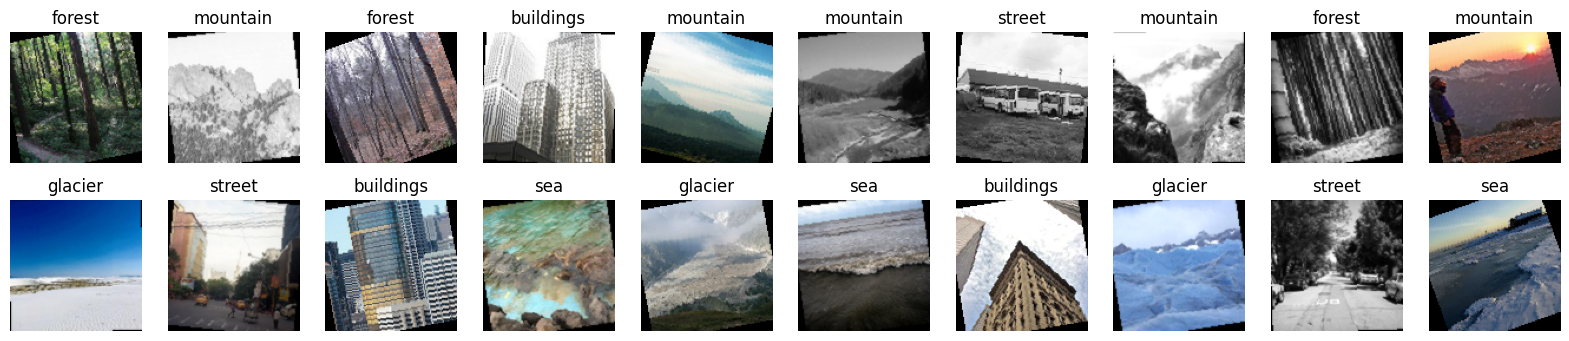

In [10]:
plt.figure(figsize=(20, 4), dpi=100)

images, labels = next(iter(trainloader))
for idx in range(20):
    plt.subplot(2, 10, idx+1)
    plt.imshow(images[idx].numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.title(CLASSES[labels[idx].item()])

In [11]:
def criterion(pred, labels, reduction="mean"):
    return F.nll_loss(pred, labels, reduction=reduction)

In [12]:
dropout_rate = 0.0

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(inplace=True), # ((112 - 5) + 2*0) / 1 + 1 = 108
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU(inplace=True), # ((108 - 5) + 2*0) / 1 + 1 = 104
            nn.MaxPool2d(kernel_size=2), # Max pool kernel size is 2x2, hence 104 / 2 = 52
            nn.BatchNorm2d(num_features=64, momentum=0.5),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1),
            nn.ReLU(inplace=True), # ((52 - 5) + 2*0) / 1 + 1 = 48
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True), # ((48 - 5) + 2*0) / 1 + 1 = 44
            nn.MaxPool2d(kernel_size=2), # Max pool kernel size is 2x2, hence 44 / 2 = 22
            nn.BatchNorm2d(num_features=256, momentum=0.5),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(inplace=True), # ((22 - 3) + 2*0) / 1 + 1 = 20
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            nn.ReLU(inplace=True), # ((20 - 3) + 2*0) / 1 + 1 = 18
            nn.MaxPool2d(kernel_size=2), # Max pool kernel size is 2x2, hence 18 / 2 = 9
            nn.BatchNorm2d(num_features=512, momentum=0.5),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
            nn.ReLU(inplace=True), # ((9 - 3) + 2*0) / 1 + 1 = 7
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(num_features=1024, momentum=0.9),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(num_features=512, momentum=0.9),
            nn.Linear(in_features=512, out_features=len(CLASSES), bias=True),
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = x.view(-1, 512*7*7)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

    def validation_step(self, loader):
        self.eval()
        test_loss = 0
        test_acc = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            pred = self(images)
            test_loss += criterion(pred, labels, reduction="sum").item() * images.size(0)
            pred = pred.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(labels.view_as(pred)).sum().item()
        test_loss /= len(loader.dataset)
        test_acc /= len(loader.dataset)
        print (f"Validation loss: {test_loss:.6f} Validation Accuracy: {test_acc:.6f}")
        return test_acc, test_loss

    def predict(self, loader):
        self.eval()
        pred = list()
        for images, _ in loader:
            images = images.to(device)
            output = self(images)
            pred.append((output.data.max(1, keepdim=True)[1]).item())
        return pred

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

In [15]:
def train(e):
    model.train(mode=True)
    train_loss = 0
    accuracy = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        pred = pred.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(trainloader.dataset)
    accuracy /= len(trainloader.dataset)
    print (f"Epoch: {e+1}/{epochs} Training loss: {loss.item():.6f} Training Accuracy: {accuracy:.6f}", end="; ")
    return train_loss

In [16]:
train_loss, test_acc, test_loss = list(), list(), list()
for i in range(epochs):
    train_loss.append(train(i))
    tmp_acc, tmp_loss = model.validation_step(testloader)
    test_acc.append(tmp_acc)
    test_loss.append(tmp_loss)

Epoch: 1/10 Training loss: 1.183170 Training Accuracy: 0.575602; Validation loss: 25.960993 Validation Accuracy: 0.699667
Epoch: 2/10 Training loss: 0.492980 Training Accuracy: 0.676714; Validation loss: 23.298303 Validation Accuracy: 0.733000
Epoch: 3/10 Training loss: 0.832503 Training Accuracy: 0.723600; Validation loss: 25.774158 Validation Accuracy: 0.705667
Epoch: 4/10 Training loss: 0.432894 Training Accuracy: 0.756021; Validation loss: 18.414697 Validation Accuracy: 0.796333
Epoch: 5/10 Training loss: 0.714067 Training Accuracy: 0.774120; Validation loss: 19.304472 Validation Accuracy: 0.783000
Epoch: 6/10 Training loss: 0.595829 Training Accuracy: 0.795853; Validation loss: 17.228510 Validation Accuracy: 0.818333
Epoch: 7/10 Training loss: 0.551087 Training Accuracy: 0.811173; Validation loss: 20.481075 Validation Accuracy: 0.772000
Epoch: 8/10 Training loss: 0.720888 Training Accuracy: 0.822788; Validation loss: 17.096208 Validation Accuracy: 0.810000
Epoch: 9/10 Training los

Text(0.5, 1.0, 'Test Loss')

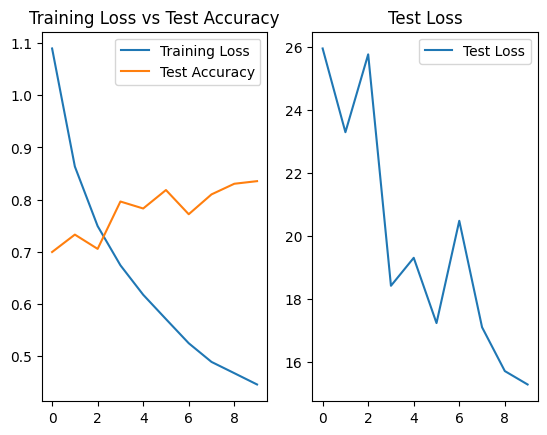

In [17]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(test_acc, label="Test Accuracy")
plt.legend(loc="upper right")
plt.title("Training Loss vs Test Accuracy")
plt.subplot(1, 2, 2)
plt.plot(test_loss, label="Test Loss")
plt.legend(loc="upper right")
plt.title("Test Loss")

In [18]:
def validset_loader(image_path):
    return Image.open(image_path)

In [19]:
validset = datasets.ImageFolder("./data/val/", transform=transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
]), loader=validset_loader)
validloader = DataLoader(validset, batch_size=1, shuffle=True)

In [20]:
print (f"Number of samples found in Test Set are: {len(validloader.dataset)}")

Number of samples found in Test Set are: 7301


In [21]:
predictions = model.predict(validloader)

In [22]:
pt.save(model, "./intel-image-classification-pytorch.pt")